# Чтение данных

In [386]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pymorphy3
from transliterate import translit, get_available_language_codes
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [387]:
filename = 'geo-reviews-dataset-2023.tskv'

all_records = []

with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
        if not line.strip():
            continue
            
        record_dict = {}
        
        pairs = line.strip().split('\t')
        
        for pair in pairs:
            try:
                key, value = pair.split('=', 1)
                record_dict[key] = value
            except ValueError:
                pass
                
        all_records.append(record_dict)

df = pd.DataFrame(all_records)

df.head()


,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


# EDA

Посмотрим на состав данных

In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  499030 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     500000 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


## Преобразование типов

In [389]:
df['rating'] = pd.to_numeric(df['rating'])
df['rating'].value_counts(dropna=False)

rating
5.0    390515
4.0     41160
1.0     34351
3.0     21686
2.0     12088
0.0       200
Name: count, dtype: int64

In [390]:
df['rubrics_list'] = df['rubrics'].str.split(';')
df.head()

,address,name_ru,rating,rubrics,text,rubrics_list
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,[Жилой комплекс]
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","[Магазин продуктов, Продукты глубокой заморозк..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",[Фитнес-клуб]
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"[Пункт проката, Прокат велосипедов, Сапсёрфинг]"
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"[Салон красоты, Визажисты, стилисты, Салон бро..."


## Заполнение пропусков

Видим, что у 970 отзывов нет названия организаций, посмотрим на эти данные

In [391]:
df[df['name_ru'].isna()].head()

,address,name_ru,rating,rubrics,text,rubrics_list
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",NaN,5.0,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе...",[Офис организации]
5716,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Гостиница действительно хорошая, удобно распол...",[Гостиница]
5717,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,Был здесь на кулинарном мастер-классе. Место а...,[Гостиница]
5718,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Тихое место, в выходные возможно и шумно так к...",[Гостиница]
5719,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к...",[Гостиница]


Судя по адресам таких организаций 576 - вручную найти и проставить названия будет сложно

In [392]:
df[df['name_ru'].isna()]['address'].value_counts()

address
Новгородская область, 49Н-1234                                                                16
Санкт-Петербург, улица Рентгена, 19                                                           16
Республика Карелия, Петрозаводск, улица Федосовой, 30                                         13
Краснодарский край, Сочи, микрорайон Центральный, Навагинская улица, 11, корп. 5              12
Новгородская область, Окуловский район, Турбинное сельское поселение, М-11, 423-й километр    11
                                                                                              ..
Москва, Дубининская улица, 67к2                                                                1
Республика Коми, Сыктывкар, Сысольское шоссе, 7/1                                              1
Хабаровск, Морская улица, 7                                                                    1
Ханты-Мансийский автономный округ, Урай, микрорайон Западный, 12Б                              1
Новосибирск, Коммунист

Но мы можем проверить, вдруг есть строки, где адрес проставлен, совпадает рубрика и есть название

In [393]:
df_with_names = df.dropna(subset=['name_ru'])

In [394]:
address_to_name_map = df_with_names.drop_duplicates(subset=['address', 'rubrics']).set_index(['address', 'rubrics'])['name_ru']

In [395]:
address_to_name_map.head()

address                                                                                                           rubrics                                                           
Екатеринбург, ул. Московская / ул. Волгоградская / ул. Печатников                                                 Жилой комплекс                                                        Московский квартал
Московская область, Электросталь, проспект Ленина, 29                                                             Магазин продуктов;Продукты глубокой заморозки;Магазин мяса, колбас     Продукты Ермолино
Краснодар, Прикубанский внутригородской округ, микрорайон имени Петра Метальникова, улица Петра Метальникова, 26  Фитнес-клуб                                                                      LimeFit
Санкт-Петербург, проспект Энгельса, 111, корп. 1                                                                  Пункт проката;Прокат велосипедов;Сапсёрфинг                                 Snow-Express
Тверь, 

In [396]:
address_to_name_map.shape

(272722,)

272 722 организации (филиалы) с известным именем

In [397]:
rows_to_fill = df['name_ru'].isnull()

In [398]:
df.loc[rows_to_fill, 'address'].map(address_to_name_map).dropna()

Series([], Name: address, dtype: object)

Понимаем, что адреса пустых организаций нигде не повторяются, где названия есть. Так как нам не особо важно название организации, а все остальные данные по ним есть, давайте сгруппируем их по адресу и рубрике (с большой вероятностью это одна и та же организация) и дадим название "Неизвестная организация N" - где N просто номер 

На всякий проверим, что нет организаций с похожими названиями

In [399]:
df[df['name_ru'].str.contains("Неизвестная") == True]

,address,name_ru,rating,rubrics,text,rubrics_list


In [400]:
df_without_names = df[df['name_ru'].isna()].copy()
df_without_names['key'] = df['address'] + df['rubrics']
df_without_names.head()

,address,name_ru,rating,rubrics,text,rubrics_list,key
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",NaN,5.0,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе...",[Офис организации],"Москва, 8-я улица Соколиной Горы, 15А, стр. 23..."
5716,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Гостиница действительно хорошая, удобно распол...",[Гостиница],"Челябинская область, Златоуст, Таганайская ули..."
5717,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,Был здесь на кулинарном мастер-классе. Место а...,[Гостиница],"Челябинская область, Златоуст, Таганайская ули..."
5718,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Тихое место, в выходные возможно и шумно так к...",[Гостиница],"Челябинская область, Златоуст, Таганайская ули..."
5719,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к...",[Гостиница],"Челябинская область, Златоуст, Таганайская ули..."


In [401]:
unique_missing_keys = df_without_names['key'].unique()
key_to_generated_name_map = {key: f"Неизвестная организация №{i}" for i, key in enumerate(unique_missing_keys, 1)}

In [402]:
df['key'] = df['address'] + df['rubrics']
df.loc[rows_to_fill, 'name_ru'] = df.loc[rows_to_fill, 'key'].map(key_to_generated_name_map)
df.head()

,address,name_ru,rating,rubrics,text,rubrics_list,key
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,[Жилой комплекс],"Екатеринбург, ул. Московская / ул. Волгоградск..."
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","[Магазин продуктов, Продукты глубокой заморозк...","Московская область, Электросталь, проспект Лен..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",[Фитнес-клуб],"Краснодар, Прикубанский внутригородской округ,..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"[Пункт проката, Прокат велосипедов, Сапсёрфинг]","Санкт-Петербург, проспект Энгельса, 111, корп...."
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"[Салон красоты, Визажисты, стилисты, Салон бро...","Тверь, Волоколамский проспект, 39Салон красоты..."


In [403]:
df = df.drop(columns=['key'])

In [404]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   address       500000 non-null  object 
 1   name_ru       500000 non-null  object 
 2   rating        500000 non-null  float64
 3   rubrics       500000 non-null  object 
 4   text          500000 non-null  object 
 5   rubrics_list  500000 non-null  object 
dtypes: float64(1), object(5)
memory usage: 22.9+ MB


Теперь все данные не пустые

## Аналитика

### Организации

In [405]:
print(f'Количество уникальных геоточек {len(df.groupby('address'))}')
print(f'Количество уникальных геоточек + рубрика {len(df.groupby(['address', 'rubrics']))}')
print(f'Количество уникальных филиалов организаций {len(df.groupby(['address', 'rubrics', 'name_ru']))}')
print(f'Количество уникальных организаций {len(df.groupby(['name_ru']))}')
print(f'Количество уникальных организаций с рубрикой {len(df.groupby(['name_ru', 'rubrics']))}')

Количество уникальных геоточек 191925
Количество уникальных геоточек + рубрика 273293
Количество уникальных филиалов организаций 276871
Количество уникальных организаций 149035
Количество уникальных организаций с рубрикой 196591


1. Количество уникальных геоточек: 191 925
Это количество уникальных физических адресов в нашем датасете. Можно думать об этом как о количестве уникальных зданий или конкретных мест на карте, где есть хотя бы одна организация.

2. Количество уникальных геоточек + рубрика: 273 293
Это количество уникальных пар (здание, тип деятельности).
Почему больше, чем п.1? (273 293 > 191 925). Потому что в одном и том же здании (один address) может быть несколько организаций с разными видами деятельности (разные rubrics). Например, в ТЦ по адресу "ул. Ленина, 1" есть "Продуктовый магазин", "Кинотеатр" и "Кафе". Это будет три разные записи для одного адреса.

3. Количество уникальных филиалов организаций: 276 871
Это самое точное представление уникального физического филиала компании. Уникальная тройка (здание, тип деятельности, название). В идеальном мире это число должно быть равно предыдущему.
Почему больше, чем п.2? (276 871 > 273 293). Это указывает на "грязные" данные. Для одной и той же пары (адрес, рубрики) существует несколько вариантов name_ru. Например, "Пятёрочка" и "Пятерочка". Разница в 3 578 (276 871 - 273 293) — это количество таких "аномальных" случаев, которые нужно чистить.

4. Количество уникальных организаций: 149 035
Это количество уникальных названий организаций в датасете. Это число показывает, сколько всего существует уникальных "брендов" или "имен".
Почему это число меньше всех предыдущих? Потому что у одного и того же бренда (одно name_ru, например, "Сбербанк") есть множество филиалов по разным адресам. groupby('name_ru') "схлопывает" все филиалы "Сбербанка" в одну группу.

5. Количество уникальных организаций с рубрикой: 196 591
Это количество уникальных пар (название_бренда, тип_деятельности).
Почему больше, чем п.4? (196 591 > 149 035). Потому что один и тот же бренд может заниматься разными видами деятельности.
Классический пример: "Яндекс". У него могут быть рубрики "IT-компания", "Такси", "Доставка еды", "Пункт выдачи заказов". Каждая такая пара ("Яндекс", "Такси"), ("Яндекс", "Доставка еды") будет считаться уникальной.
Другой пример: "Магнит". Могут быть рубрики "Магазин продуктов" или "Супермаркет" - в зависимости от размерка магазина.


#### Примеры из датасета

In [406]:
grouped = df.groupby(['address', 'rubrics'])['name_ru'].nunique()

inconsistent_groups = grouped[grouped > 1]

print(f"Найдено {len(inconsistent_groups)} пар (адрес, рубрики) с несколькими уникальными названиями")

print("\n--- Примеры неконсистентных данных ---\n")

inconsistent_indices = inconsistent_groups.index
for i, (address, rubrics) in enumerate(inconsistent_indices[5:10]):
    example_df = df[
        (df['address'] == address) & 
        (df['rubrics'] == rubrics)
    ]
    unique_names = example_df['name_ru'].unique()
    
    print(f"Пример #{i+1}")
    print(f"Адрес: {address}")
    print(f"Рубрики: {rubrics}")
    print(f"Обнаружены разные названия: {list(unique_names)}")
    print("-" * 20 + "\n")



Найдено 2906 пар (адрес, рубрики) с несколькими уникальными названиями

--- Примеры неконсистентных данных ---

Пример #1
Адрес: Алтайский край, Смоленский район
Рубрики: Горная вершина
Обнаружены разные названия: ['Гора Церковка', 'Глухариные скалы']
--------------------

Пример #2
Адрес: Алтайский район, игорная зона Сибирская Монета, 66
Рубрики: Гостиница
Обнаружены разные названия: ['Altai Palace', 'Алтай Пэлас']
--------------------

Пример #3
Адрес: Амурская область, Благовещенск
Рубрики: Жанровая скульптура
Обнаружены разные названия: ['Железный бык', 'Памятник казакам-первопоселенцам Приамурья']
--------------------

Пример #4
Адрес: Архангельск, Воскресенская улица, 8
Рубрики: Гостиница
Обнаружены разные названия: ['В центре', 'Отель на Воскресенской']
--------------------

Пример #5
Адрес: Архангельск, набережная Северной Двины, 32
Рубрики: Гостиница
Обнаружены разные названия: ['Адмирал', 'Северница']
--------------------



#### ИТОГО

у нас следующие проблемы:
* идентификатор организации - это адрес + рубрики + название
* при этом название может быть записано по разному - буквы е и ё, английский или транскрипт, большие/маленькие буквы
* chain - сеть - будем считать одну организацию без привязки к адресу, но будем привязываться к рубрикам, чтобы избежать абсолютно разные направления организаций просто с одинаковыми названиями

#### Решаем проблемы

План действий:
1. Приведение к нижнему регистру: Убирает проблемы с заглавными буквами.
2. Замена ё на е: Стандартизирует наиболее частую вариацию в русских словах.
3. Удаление знаков препинания и спецсимволов: Избавляет от разницы вроде "Вкусно - и точка" vs "Вкусно и точка".
4. Удаление лишних пробелов: Убирает случайные двойные пробелы или пробелы в начале/конце строки.
5. Лемматизация: Приводит слова к их начальной форме (словарной). Это решает проблему единственного и множественного числа ("цветок" vs "цветы"). Для этого мы будем использовать библиотеку pymorphy3.
6. Транслитерация: Попытаемся привести английские названия и транслит к единому виду. Это сложная задача, но мы можем реализовать базовую версию.

In [407]:
morph = pymorphy3.MorphAnalyzer()

In [408]:
def normalize_name(name):
    name = name.lower()
    
    try:
        name_ru = translit(name, 'ru')
        if name_ru and re.search('[а-я]', name_ru):
            name = name_ru
    except Exception:
        pass

    name = re.sub(r'[^а-яa-z0-9\s-]', '', name)
    
    words = name.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    name = ' '.join(lemmatized_words)
    
    name = re.sub(r'\s+', ' ', name).strip()
    name = name.replace('ё', 'е')
    
    return name

df['name_ru_normalized'] = df['name_ru'].apply(normalize_name)

df[df['name_ru'] != df['name_ru_normalized']][['name_ru', 'name_ru_normalized']].head(10)


,name_ru,name_ru_normalized
0,Московский квартал,московский квартал
1,Продукты Ермолино,продукт ермолин
2,LimeFit,лимефита
3,Snow-Express,сноw-еxпресс
4,Студия Beauty Brow,студия беаут броw
5,Tele2,теле2
6,У тещи,у теща
7,Smoking Park,смокинг парк
8,Jinju,йиня
9,Jinju,йиня


Посмотрим на найденный пример

In [409]:
df[df['name_ru'] == "Алтай Пэлас"]

,address,name_ru,rating,rubrics,text,rubrics_list,name_ru_normalized
413471,"Алтайский район, игорная зона Сибирская Монета...",Алтай Пэлас,4.0,Гостиница,Достаточно хорошее место для отдыха. Горный во...,[Гостиница],алтай пэласа
413472,"Алтайский район, игорная зона Сибирская Монета...",Алтай Пэлас,5.0,Гостиница,"Отличное обслуживание, умный с юморм персонал....",[Гостиница],алтай пэласа
413473,"Алтайский район, игорная зона Сибирская Монета...",Алтай Пэлас,5.0,Гостиница,"Рекомендую! Летом или зимой, весной или тем бо...",[Гостиница],алтай пэласа


In [410]:
df[df['name_ru'] == "Altai Palace"]

,address,name_ru,rating,rubrics,text,rubrics_list,name_ru_normalized
48525,"Алтайский район, игорная зона Сибирская Монета...",Altai Palace,5.0,Гостиница,"Самое лучшее место на Алтае. Всегда чисто, уют...",[Гостиница],алтая палац
48526,"Алтайский район, игорная зона Сибирская Монета...",Altai Palace,3.0,Гостиница,Плюсы отеля:\n1. Хорошая детская комната. Сыну...,[Гостиница],алтая палац
48527,"Алтайский район, игорная зона Сибирская Монета...",Altai Palace,5.0,Гостиница,Оочень красивое место для отдыха с семьей и бе...,[Гостиница],алтая палац


Понимаем, что тут не сработала транскрипция, заменим это вручную. К сожалению, отсмотреть весь датасет невозможно так, но надеемся, что большиснтво похожих ситуаций мы решили

In [411]:
rows_to_change = df['name_ru'] == "Altai Palace"
df.loc[rows_to_change,'name_ru_normalized'] = "алтай пэласа"

Теперь давайте посмотрим, насколько "схлопнулись" наши группы после нормализации

In [412]:
temp_df = df.copy()
temp_df['name_ru'] = temp_df['name_ru_normalized'] 

print("ДО нормализации:")
print(f'Количество уникальных геоточек {len(df.groupby('address'))}')
print(f'Количество уникальных геоточек + рубрика {len(df.groupby(['address', 'rubrics']))}')
print(f'Количество уникальных филиалов организаций {len(df.groupby(['address', 'rubrics', 'name_ru']))}')
print(f'Количество уникальных организаций {len(df.groupby(['name_ru']))}')
print(f'Количество уникальных организаций с рубрикой {len(df.groupby(['name_ru', 'rubrics']))}')


print("\nПОСЛЕ нормализации:")
print(f'Количество уникальных геоточек {len(temp_df.groupby('address'))}')
print(f'Количество уникальных геоточек + рубрика {len(temp_df.groupby(['address', 'rubrics']))}')
print(f'Количество уникальных филиалов организаций {len(temp_df.groupby(['address', 'rubrics', 'name_ru']))}')
print(f'Количество уникальных организаций {len(temp_df.groupby(['name_ru']))}')
print(f'Количество уникальных организаций с рубрикой {len(temp_df.groupby(['name_ru', 'rubrics']))}')

ДО нормализации:
Количество уникальных геоточек 191925
Количество уникальных геоточек + рубрика 273293
Количество уникальных филиалов организаций 276871
Количество уникальных организаций 149035
Количество уникальных организаций с рубрикой 196591

ПОСЛЕ нормализации:
Количество уникальных геоточек 191925
Количество уникальных геоточек + рубрика 273293
Количество уникальных филиалов организаций 276852
Количество уникальных организаций 140191
Количество уникальных организаций с рубрикой 193587


Итого, мы поняли, что рассматривать отзывы можем по двум сценариям:
1. По филиалу организации - то есть идентификатор адрес+рубрики+название
3. По сети, разделяя тип деятельности - то есть по названию и рубрики, так как названия совершенно разных организаций может дублироваться

### Рубрики

In [413]:
df_rubrics = df.copy()
exploded_rubrics = df_rubrics.explode('rubrics_list')

Посмотрим, каких рубрик больше всего

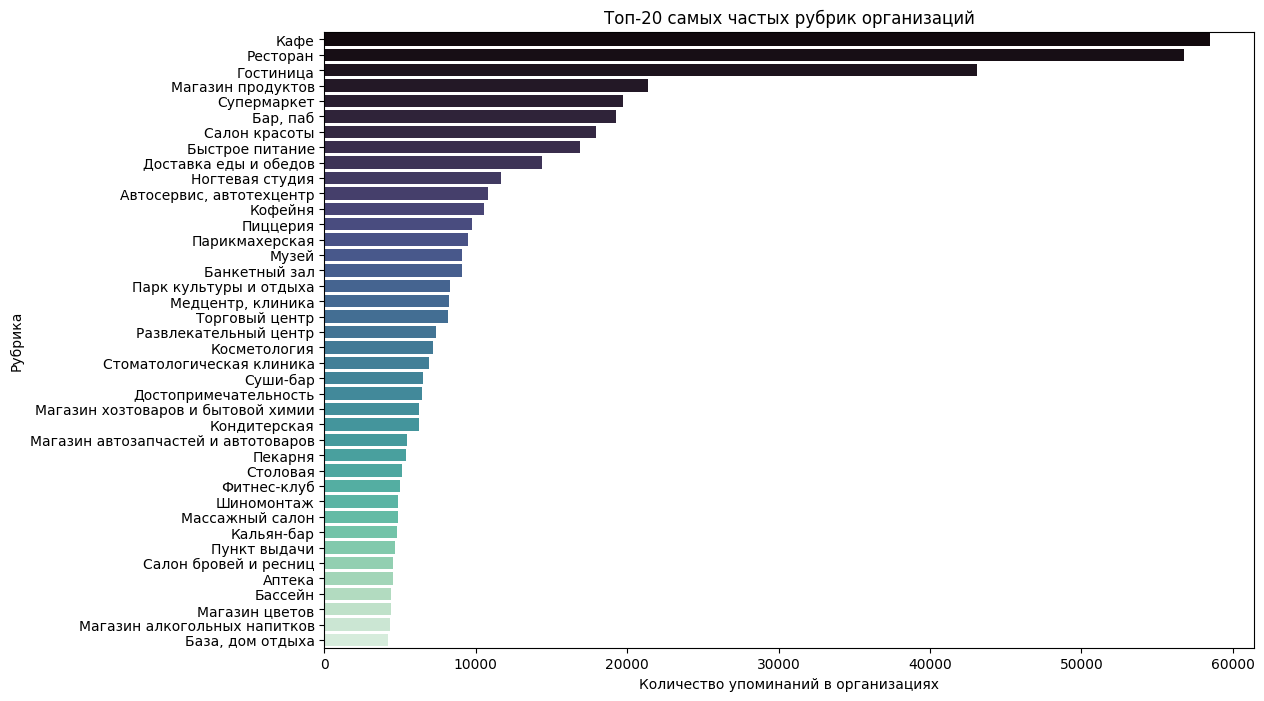

In [414]:
top_rubrics = exploded_rubrics['rubrics_list'].value_counts().nlargest(40)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_rubrics.index, x=top_rubrics.values, palette='mako',  hue=top_rubrics.index)
plt.title('Топ-20 самых частых рубрик организаций')
plt.xlabel('Количество упоминаний в организациях')
plt.ylabel('Рубрика')
plt.show()

Наша бизнес цель связана именно с едальными организациями, поэтому оставим только те, у которых в рубриках есть Кафе, Ресторан, Бар, паб, Быстрое питание, Доставка еды и обедов, Кофейня, Пиццерия, Банкетный зал, Суши-бар, Кондитерская, Пекарня, Столовая, Кальян-бар

И сколько их вообще может быть

In [415]:
exploded_rubrics['rubrics_list'].nunique()

1370

In [416]:
df.sample(20)

,address,name_ru,rating,rubrics,text,rubrics_list,name_ru_normalized
379180,"Санкт-Петербург, Авангардная улица, 31",Street Food,1.0,Быстрое питание,Во время открытия этого заведения работал отли...,[Быстрое питание],стреять фоод
214271,"Нижний Новгород, улица Глеба Успенского, 16А",АНО ЦСР Территория Спорта,5.0,"Спортивный клуб, секция;Спортивное объединение...","Замечательный спортивный клуб, профессиональны...","[Спортивный клуб, секция, Спортивное объединен...",ано цср территория спорт
9013,"Республика Крым, Судак, улица Савельева, 10",Зима Лето,5.0,Гостиница,Ездим всей семьёй и 4 человек отдыхать в Судак...,[Гостиница],зима лето
372145,"Ярославская область, Переславль-Залесский, Пле...",Флай Улей,5.0,Кафе;Развлекательный центр,Отличное место для семейного отдыха-детям есть...,"[Кафе, Развлекательный центр]",флай уля
71382,"Санкт-Петербург, проспект Александровской Ферм...",Фаркоп.ру,5.0,Автомобильные прицепы;Автоаксессуары;Магазин а...,Поставили фаркоп на инфинити ех35. Самый бюдже...,"[Автомобильные прицепы, Автоаксессуары, Магази...",фаркопра
210943,"Ставропольский край, Пятигорск, проспект 40 ле...",Chillout lounge bar,5.0,Кальян-бар;Кафе;Ресторан,"Если бы можно было, я бы поставила 10. Редко в...","[Кальян-бар, Кафе, Ресторан]",чиллоут лоунг бар
305573,"Мурманская область, Мончегорск, проспект Киров...",Пышка,5.0,Столовая,"Бываю там почти каждый день. Вкусно, чисто, пр...",[Столовая],пышка
35302,"Московская область, Жуковский, улица Наркомвод, 3","Международный аэропорт Жуковский, терминал А",3.0,Терминал аэропорта,"Небольшой терминал, с грязными туалетами. Дьюи...",[Терминал аэропорта],международный аэропорт жуковский терминал а
235858,"Москва, Каширское шоссе, 61Г",Замес,5.0,Ресторан,"Вежливый персонал, чисто, интересный интерьер....",[Ресторан],замес
425921,"Санкт-Петербург, Народная улица, 42к2",Нотариус Вострецова В. Л.,5.0,Нотариусы,"Очень хорошая компания, ни разу не пожалели, ч...",[Нотариусы],нотариус вострецов в л


Очень много! Но на семпле видно, что первая рубрика скорее является главное и основной, так что отделим ее как main

In [417]:
df_rubrics['main_rubric'] = df_rubrics['rubrics_list'].apply(lambda x: x[0])
df_rubrics.head()

,address,name_ru,rating,rubrics,text,rubrics_list,name_ru_normalized,main_rubric
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,[Жилой комплекс],московский квартал,Жилой комплекс
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","[Магазин продуктов, Продукты глубокой заморозк...",продукт ермолин,Магазин продуктов
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",[Фитнес-клуб],лимефита,Фитнес-клуб
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"[Пункт проката, Прокат велосипедов, Сапсёрфинг]",сноw-еxпресс,Пункт проката
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"[Салон красоты, Визажисты, стилисты, Салон бро...",студия беаут броw,Салон красоты


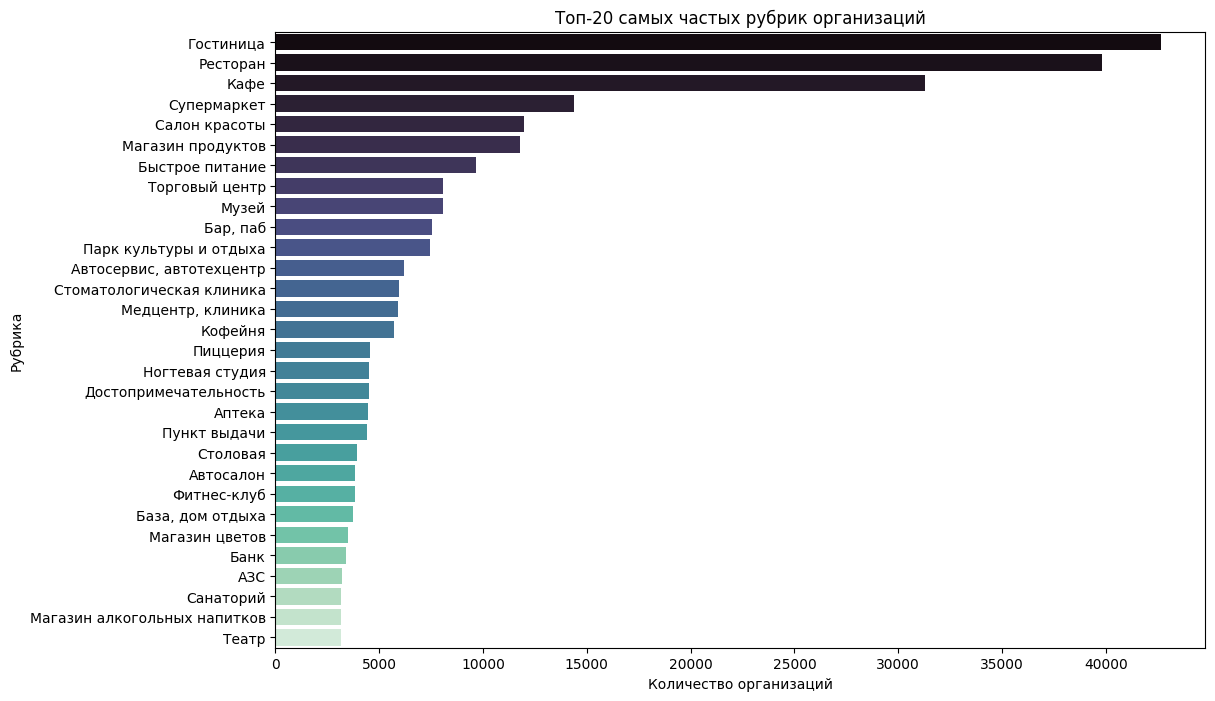

In [418]:
top_rubrics = df_rubrics['main_rubric'].value_counts().nlargest(30)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_rubrics.index, x=top_rubrics.values, palette='mako', hue=top_rubrics.index)
plt.title('Топ-20 самых частых рубрик организаций')
plt.xlabel('Количество организаций')
plt.ylabel('Рубрика')
plt.show()

Топ изменился. Оставим для основного датасета преобразованное поле, где будет лист рубрик и новое поле с главной рубрикой

In [419]:
df['main_rubric'] = df['rubrics_list'].apply(lambda x: x[0])
df.head()

,address,name_ru,rating,rubrics,text,rubrics_list,name_ru_normalized,main_rubric
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,[Жилой комплекс],московский квартал,Жилой комплекс
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","[Магазин продуктов, Продукты глубокой заморозк...",продукт ермолин,Магазин продуктов
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",[Фитнес-клуб],лимефита,Фитнес-клуб
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"[Пункт проката, Прокат велосипедов, Сапсёрфинг]",сноw-еxпресс,Пункт проката
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"[Салон красоты, Визажисты, стилисты, Салон бро...",студия беаут броw,Салон красоты


А также оставим только те организации, кооторые считаются едальными

In [420]:
eda_orgs = ["Кафе", "Ресторан", "Бар, паб", "Быстрое питание", "Доставка еды и обедов", "Кофейня", "Пиццерия", "Банкетный зал", "Суши-бар", "Кондитерская", "Пекарня", "Столовая", "Кальян-бар"]
search_pattern = '|'.join([re.escape(rubric) for rubric in eda_orgs])
mask = df['rubrics'].str.contains(search_pattern)
df_new = df[mask].copy()

In [421]:
df_new.shape

(122632, 8)

Осталось 122 632 отзывово

И ради интереса посмотри на наши группировки организаций

In [422]:
print("ДО нормализации:")
print(f'Количество уникальных геоточек {len(df_new.groupby('address'))}')
print(f'Количество уникальных геоточек + рубрика {len(df_new.groupby(['address', 'rubrics']))}')
print(f'Количество уникальных филиалов организаций {len(df_new.groupby(['address', 'rubrics', 'name_ru']))}')
print(f'Количество уникальных организаций {len(df_new.groupby(['name_ru']))}')
print(f'Количество уникальных организаций с рубрикой {len(df_new.groupby(['name_ru', 'rubrics']))}')

print("\nС главной рубрикой:")
print(f'Количество уникальных геоточек {len(df_new.groupby('address'))}')
print(f'Количество уникальных геоточек + рубрика {len(df_new.groupby(['address', 'main_rubric']))}')
print(f'Количество уникальных филиалов организаций {len(df_new.groupby(['address', 'main_rubric', 'name_ru_normalized']))}')
print(f'Количество уникальных организаций {len(df_new.groupby(['name_ru_normalized']))}')
print(f'Количество уникальных организаций с рубрикой {len(df_new.groupby(['name_ru_normalized', 'main_rubric']))}')


ДО нормализации:
Количество уникальных геоточек 43353
Количество уникальных геоточек + рубрика 51843
Количество уникальных филиалов организаций 52691
Количество уникальных организаций 29314
Количество уникальных организаций с рубрикой 39811

С главной рубрикой:
Количество уникальных геоточек 43353
Количество уникальных геоточек + рубрика 49891
Количество уникальных филиалов организаций 52651
Количество уникальных организаций 27156
Количество уникальных организаций с рубрикой 32496


Посмотрим, где одиннаковые названия, но разные рубрики

In [423]:
multi_profile_orgs = df_new.groupby('name_ru_normalized')['rubrics'].nunique()
multi_profile_orgs = multi_profile_orgs[multi_profile_orgs > 1]
multi_profile_orgs = multi_profile_orgs.sort_values(ascending=False)
top_name = multi_profile_orgs.head(1).index

org_df = df_new[df_new['name_ru_normalized'] == top_name[0]]
print(top_name[0])
org_df['rubrics'].unique()

буханка


array(['Кафе;Пекарня;Кофейня', 'Пекарня', 'Пекарня;Кафе',
       'Кофейня;Пекарня;Кофе с собой', 'Кафе', 'Пекарня;Кафе;Кофейня',
       'Кондитерская;Пекарня;Кафе;Ресторан', 'Кафе;Пекарня;Кофе с собой',
       'Пекарня;Кафе;Кофе с собой', 'Кафе;Пекарня',
       'Пекарня;Кондитерская;Кофейня', 'Пекарня;Быстрое питание;Кофейня',
       'Пекарня;Кафе;Магазин продуктов;Кондитерская',
       'Пекарня;Кофе с собой', 'Пекарня;Кофейня',
       'Пекарня;Кафе;Магазин продуктов', 'Пекарня;Кондитерская',
       'Пекарня;Кофейня;Кофе с собой', 'Кофейня',
       'Кафе;Пекарня;Кондитерская', 'Кофейня;Пекарня',
       'Пекарня;Кафе;Кондитерская', 'Пекарня;Магазин продуктов;Кофейня',
       'Кофейня;Пекарня;Кафе;Кофе с собой', 'Пекарня;Магазин продуктов',
       'Кафе;Пекарня;Ресторан', 'Пекарня;Магазин продуктов;Кофе с собой',
       'Кофейня;Пекарня;Мороженое', 'Пекарня;Кафе;Кондитерская;Кофейня',
       'Пекарня;Кафе;Ресторан;Кондитерская'], dtype=object)

In [424]:
multi_profile_orgs = df_new.groupby(['name_ru_normalized', 'address'])['rubrics'].nunique()
multi_profile_orgs = multi_profile_orgs[multi_profile_orgs > 1]
multi_profile_orgs = multi_profile_orgs.sort_values(ascending=False)
top_name = multi_profile_orgs.head(1).index

org_df = df_new[df_new['name_ru_normalized'] == top_name[0][0]]
print(top_name[0])
org_df['rubrics'].unique()

('моуса хоуса', 'Санкт-Петербург, улица Академика Павлова, 5')


array(['Ресторан;Развлекательный центр',
       'Развлекательный центр;Ресторан;Детская площадка', 'Ресторан'],
      dtype=object)

Итого именно для едален не стоит брать главную рубрику, но для сетей по-другому никак не уберешь условие с тем, что две разных орги могут иметь абсолютно одиннаковые орги

### Рейтинг

In [425]:
df_new['rating'].describe()

count    122632.000000
mean          4.420559
std           1.183983
min           0.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

Видим, что большинство оценок положительного характера и при обучении стоит учесть дисбаланс классов

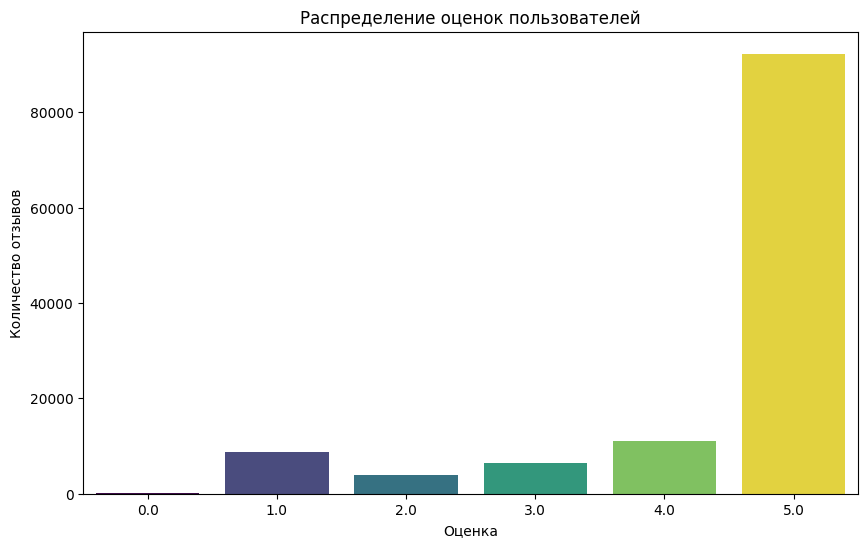

In [426]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df_new, palette='viridis', hue='rating', legend=False)
plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Количество отзывов')
plt.show()

### Идентификаторы

Итого, решаем так, что:
* Организация (organization_id): Конкретный физический филиал. Его уникальность определяется местом, названием и типом деятельности. - тип деятельности можно удалить, так как две едальные организации с одиннаковым названием в одном доме звучит странно. Раньше мы решали проблему многопрофильных организаций
* Сеть (chain_id): Бренд или бизнес-направление. Уникальность определяется названием и типом деятельности, вне зависимости от местоположения.

Где тип деятельности будем брать как главную рубрику

In [429]:
df_new['organization_id'] = df_new['address'] + '|' + df_new['name_ru_normalized']
df_new['chain_id'] = df_new['main_rubric'] + '|' + df_new['name_ru_normalized']

df_new['organization_id'] = pd.factorize(df_new['organization_id'])[0]
df_new['chain_id'] = pd.factorize(df_new['chain_id'])[0]

num_orgs = df_new['organization_id'].nunique()
num_chains = df_new['chain_id'].nunique()

print(f"\nИтог:")
print(f"Создано {num_orgs} уникальных идентификаторов организаций (филиалов)")
print(f"Создано {num_chains} уникальных идентификаторов сетей (брендов/бизнес-направлений)")


Итог:
Создано 52598 уникальных идентификаторов организаций (филиалов)
Создано 32496 уникальных идентификаторов сетей (брендов/бизнес-направлений)


In [431]:
df_new.head()

,address,name_ru,rating,rubrics,text,rubrics_list,name_ru_normalized,main_rubric,organization_id,chain_id
6,"Воронежская область, Богучарский район, М-4 До...",У тещи,4.0,Кафе,Глубинка страны во всех своих проявлениях. Асс...,[Кафе],у теща,Кафе,0,0
8,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,Кафе;Кофейня,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...","[Кафе, Кофейня]",йиня,Кафе,1,1
9,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,Кафе;Кофейня,"Не очень удобное расположение, от метро идти м...","[Кафе, Кофейня]",йиня,Кафе,1,1
12,"Кемерово, проспект Ленина, 59А",Прованс,5.0,Кондитерская,Вкусное место в центре города. Разнообразное ...,[Кондитерская],прованс,Кондитерская,2,2
13,"Краснодарский край, городской округ Сочи, посё...",Пандок,2.0,Ресторан,"Самый большой плюс это месторасположение, набе...",[Ресторан],пандок,Ресторан,3,3


Посмотрим на самые крупные сети по количеству филиалов

In [434]:
df_new['chain_size'] = df_new.groupby('chain_id')['organization_id'].transform('nunique')
top_chains_df = df_new[['chain_id', 'name_ru', 'name_ru_normalized', 'main_rubric', 'chain_size']].drop_duplicates(subset=['chain_id'])

top_chains_df.sort_values(by='chain_size', ascending=False).head(10)

,chain_id,name_ru,name_ru_normalized,main_rubric,chain_size
636,100,Вкусно — и точка,вкусно и точка,Быстрое питание,541
799,116,KFC,кфц,Быстрое питание,443
320,49,Додо Пицца,додый пицца,Пиццерия,384
1334,167,Столовая,столовая,Столовая,356
661,103,Бургер Кинг,бургер кинг,Быстрое питание,346
529,84,Кафе,кафе,Кафе,205
8919,646,Вкусно — и точка. Авто,вкусно и точка авто,Быстрое питание,165
846,121,Шаурма,шаурма,Быстрое питание,153
11556,884,Мята Lounge,мятый лоунг,Кальян-бар,128
4081,317,Шоколадница,шоколадница,Кофейня,123


Теперь для анализа полседующего еще добавим столбец количества отзывов по сети и организации, пока не будем удалять те, где всего 1 штука, вдруг пригодятся, просто пометим их

In [435]:
df_new['reviews_per_organization'] = df_new.groupby('organization_id')['rating'].transform('count')
df_new['reviews_per_chain'] = df_new.groupby('chain_id')['rating'].transform('count')
df_new.head()

,address,name_ru,rating,rubrics,text,rubrics_list,name_ru_normalized,main_rubric,organization_id,chain_id,chain_size,reviews_per_organization,reviews_per_chain
6,"Воронежская область, Богучарский район, М-4 До...",У тещи,4.0,Кафе,Глубинка страны во всех своих проявлениях. Асс...,[Кафе],у теща,Кафе,0,0,1,1,1
8,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,Кафе;Кофейня,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...","[Кафе, Кофейня]",йиня,Кафе,1,1,1,2,2
9,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,Кафе;Кофейня,"Не очень удобное расположение, от метро идти м...","[Кафе, Кофейня]",йиня,Кафе,1,1,1,2,2
12,"Кемерово, проспект Ленина, 59А",Прованс,5.0,Кондитерская,Вкусное место в центре города. Разнообразное ...,[Кондитерская],прованс,Кондитерская,2,2,1,1,1
13,"Краснодарский край, городской округ Сочи, посё...",Пандок,2.0,Ресторан,"Самый большой плюс это месторасположение, набе...",[Ресторан],пандок,Ресторан,3,3,1,2,2


In [436]:
single_review_orgs_count = df_new[df_new['reviews_per_organization'] == 1]['organization_id'].nunique()
total_orgs_count = df_new['organization_id'].nunique()
percentage_orgs = (single_review_orgs_count / total_orgs_count) * 100

print(f"Всего уникальных филиалов: {total_orgs_count}")
print(f"Из них с 1 отзывом: {single_review_orgs_count}")
print(f"Доля филиалов с 1 отзывом: {percentage_orgs:.2f}%")

Всего уникальных филиалов: 52598
Из них с 1 отзывом: 29885
Доля филиалов с 1 отзывом: 56.82%


In [443]:
single_review_chains_count = df_new[df_new['reviews_per_chain'] == 1]['chain_id'].nunique()
total_chains_count = df_new['chain_id'].nunique()
percentage_chains = (single_review_chains_count / total_chains_count) * 100

print(f"\nВсего уникальных сетей: {total_chains_count}")
print(f"Из них с 1 отзывом: {single_review_chains_count}")
print(f"Доля сетей с 1 отзывом: {percentage_chains:.2f}%")


Всего уникальных сетей: 32496
Из них с 1 отзывом: 15555
Доля сетей с 1 отзывом: 47.87%


Так как мало отзывов на организацию очень неинформативно - мнение может быть сильно смещено и оценка необъективна, то мы решили оставить только те отзывы и организации, где reviews_per_organization > 4

In [444]:
len(df_new[df_new['reviews_per_organization'] > 2])

72451

In [445]:
len(df_new[df_new['reviews_per_organization'] > 4])

48866

Решаем оставлять орги, где хотя бы 3 отзыва есть

In [446]:
df_more_2 = df_new[df_new['reviews_per_organization'] > 2].copy()

In [447]:
single_review_orgs_count = df_more_2[df_more_2['reviews_per_organization'] == 1]['organization_id'].nunique()
total_orgs_count = df_more_2['organization_id'].nunique()
percentage_orgs = (single_review_orgs_count / total_orgs_count) * 100

print(f"Всего уникальных филиалов: {total_orgs_count}")
print(f"Из них с 1 отзывом: {single_review_orgs_count}")
print(f"Доля филиалов с 1 отзывом: {percentage_orgs:.2f}%")

Всего уникальных филиалов: 12565
Из них с 1 отзывом: 0
Доля филиалов с 1 отзывом: 0.00%


Итого остается 12,5к организаций 

In [448]:
df_more_2.to_csv('dataset.csv')